In [1]:
import zipfile
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as snb

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
parent_path = '/content/drive/My Drive/AIML/facial_keypoints_detection/'
data_path = os.path.join(parent_path,'data')
train_path = os.path.join(data_path,'training/training.csv')
test_path = os.path.join(data_path,'test/test.csv')
lookup_table_path = os.path.join(data_path,'IdLookupTable.csv')

In [4]:
def unzip_folder(folder_name):
  path = os.path.join(data_path, folder_name)
  zip_ref = zipfile.ZipFile(path,'r')
  path = os.path.join(data_path, f"{folder_name.split('.')[0]}")
  zip_ref.extractall(path)
  zip_ref.close()


In [5]:
# unzip_folder('test.zip')
# unzip_folder('training.zip')

In [6]:
# Read train data
train_data = pd.read_csv(train_path)

In [7]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [8]:
train_data.dropna(inplace=True)

In [9]:
train_data.shape

(2140, 31)

In [10]:
# let's check missing vlues
train_data.isna().any().value_counts()

False    31
dtype: int64

In [11]:
# Fill missing values with previous value
train_data.fillna('ffill',inplace=True)

In [12]:
train_data.isna().any().value_counts()

False    31
dtype: int64

In [13]:
def get_image(data):
  img_list = []
  for idx in range(len(data)):
    img = list(map(lambda x: 0 if '' == x else int(x),data['Image'].iloc[idx].split(' ')))
    img_list.append(img)
  images = np.array(img_list,dtype = 'float').reshape(-1,96,96,1) 
  return images

train_images = get_image(train_data)

In [14]:
train_images.shape

(2140, 96, 96, 1)

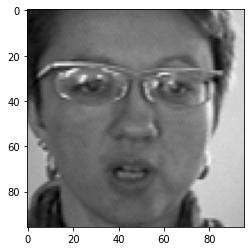

In [15]:
plt.imshow(train_images[10].reshape(96,96),cmap='gray')

In [16]:
y_train = train_data.drop(columns=['Image'])
y_train = y_train.to_numpy()
type(y_train),y_train.shape

(numpy.ndarray, (2140, 30))

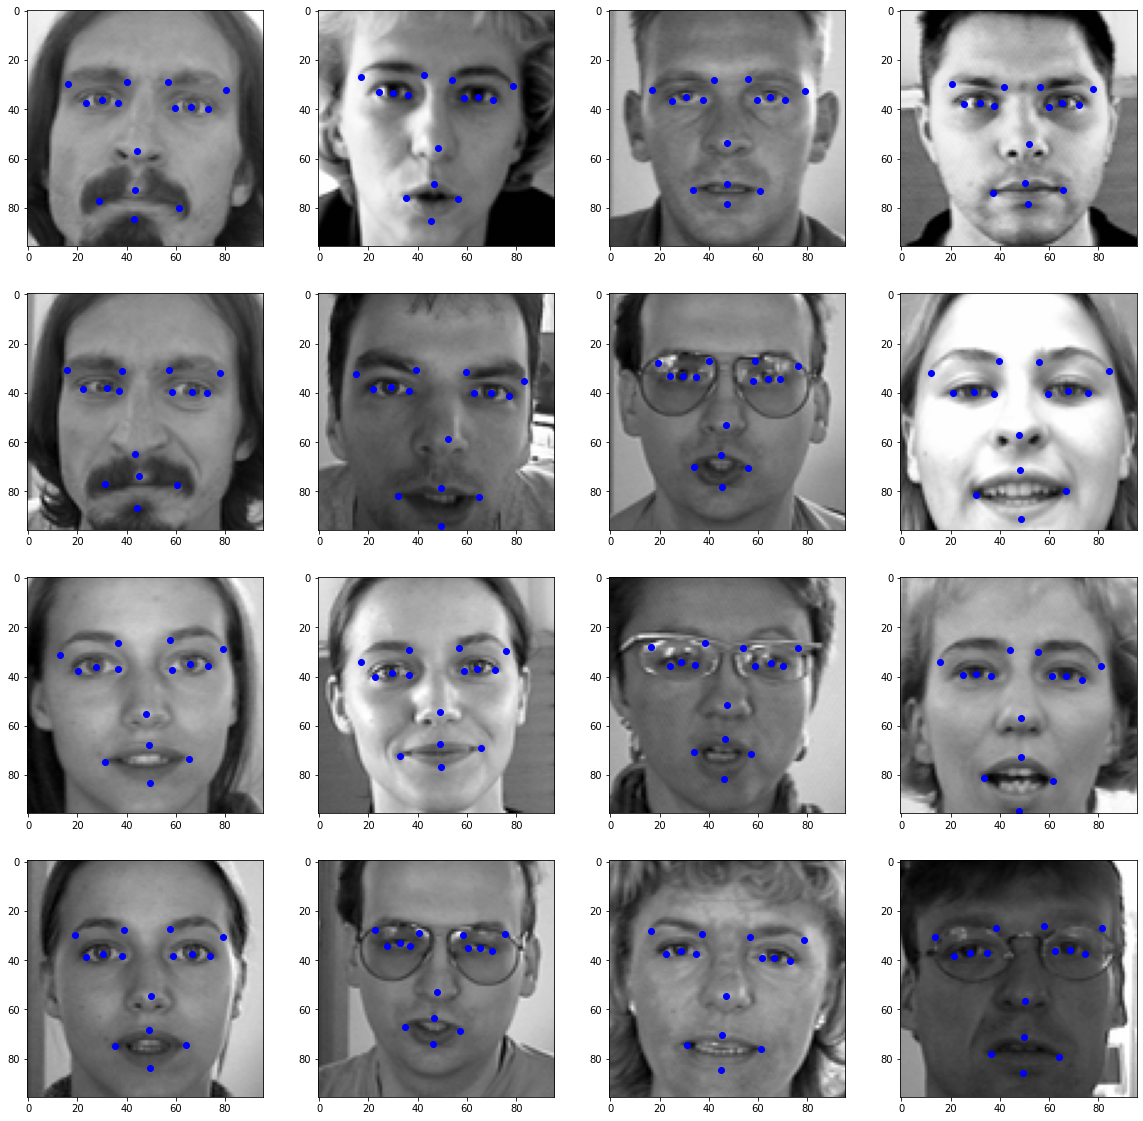

In [17]:
n = 16
cols = 4
height = max(20, int(n/cols))
plt.figure(figsize=(20, height))
for idx in range(n):
  plt.subplot(int(n/cols),cols,idx+1)
  plt.imshow(train_images[idx].reshape(96,96),cmap='gray')
  for kid in range(0,30,2):
    plt.plot(train_data.loc[idx][kid],train_data.loc[idx][kid+1],'bo')

**Preprocessing data**

In [18]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPool2D,Input,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

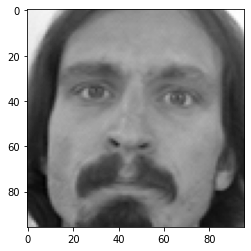

In [19]:
train_images = train_images/255
plt.imshow(train_images[0].reshape((96,96)),cmap='gray')

In [33]:
from pandas.core.common import flatten
def create_model(in_shape=(96,96,1)):
  
  visible = Input(shape=in_shape)
  # 1
  x = Conv2D(64,3,padding='same',activation='relu')(visible)
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  # 2
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  # 3
  x = Conv2D(256,3,padding='same',activation='relu')(x)
  x = Conv2D(256,3,padding='same',activation='relu')(x)
  x = Conv2D(256,3,padding='same',activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  # 4
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  # 4
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = Conv2D(512,3,padding='same',activation='relu')(x)
  x = MaxPool2D(pool_size=(2,2))(x)

  x = Flatten()(x)  
  x = Dense(1024,activation='relu')(x)
  x = Dense(1024,activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(30)(x)
  model = Model(inputs=visible,outputs=output)
  return model

In [34]:
model = create_model()
# plot_model(model,show_shapes=True)
# model.summary()

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 128)       147584    
                                                           

In [36]:
model.compile(optimizer='Adam',loss='mse',metrics=['mae','accuracy'])

In [37]:
model.fit(x=train_images,y=y_train,epochs=50,batch_size=32)

Epoch 1/50
67/67 [==============================] - 21s 215ms/step - loss: 73451.4688 - mae: 52.3083 - accuracy: 0.2051
Epoch 2/50
67/67 [==============================] - 13s 190ms/step - loss: 59.2608 - mae: 6.0800 - accuracy: 0.4056
Epoch 3/50
67/67 [==============================] - 13s 191ms/step - loss: 45.6886 - mae: 5.2915 - accuracy: 0.4224
Epoch 4/50
67/67 [==============================] - 13s 193ms/step - loss: 39.5312 - mae: 4.8954 - accuracy: 0.4977
Epoch 5/50
67/67 [==============================] - 13s 192ms/step - loss: 37.3340 - mae: 4.7256 - accuracy: 0.5056
Epoch 6/50
67/67 [==============================] - 13s 190ms/step - loss: 33.8151 - mae: 4.4920 - accuracy: 0.5327
Epoch 7/50
67/67 [==============================] - 13s 191ms/step - loss: 33.3609 - mae: 4.4380 - accuracy: 0.5561
Epoch 8/50
67/67 [==============================] - 13s 191ms/step - loss: 29.4747 - mae: 4.1662 - accuracy: 0.5724
Epoch 9/50
67/67 [==============================] - 13s 190ms/step -

Test

In [23]:
test_data = pd.read_csv(test_path)

In [24]:
test_data.head().T

,0,1,2,3,4
ImageId,1,2,3,4,5
Image,182 183 182 182 180 180 176 169 156 137 124 10...,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,177 176 174 170 169 169 168 166 166 166 161 14...,176 174 174 175 174 174 176 176 175 171 165 15...,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [30]:
test_images = get_image(test_data)

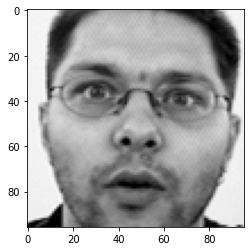

In [31]:
plt.imshow(test_images[10].reshape(96,96),cmap='gray')

In [48]:
test_data.shape

(1783, 2)

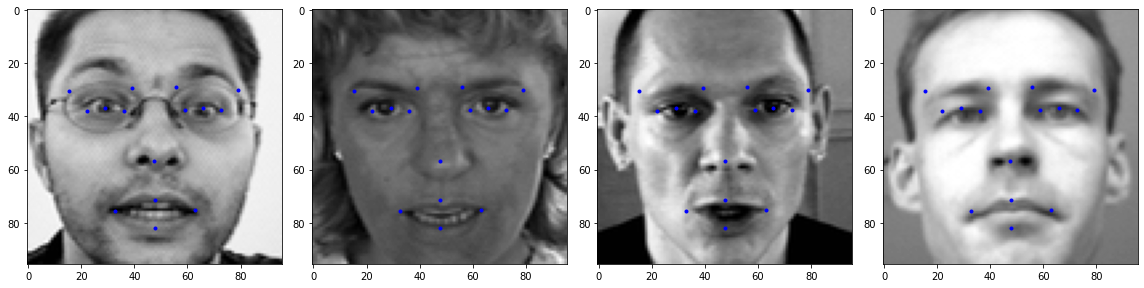

In [84]:
def prediction(test):
  prediciotns = []
  ids = []
  cols = 4
  rows = max(20,int(len(test)/cols)) 
  plt.figure(figsize=(16, 20))
  plt.subplots_adjust(hspace=0.5)
  for idx in range(len(test)):
    iid = test['ImageId'].iloc[idx]
    img = list(map(lambda x: 0 if '' == x else int(x),test['Image'].iloc[idx].split(' ')))
    img = (np.asarray(img)/255).reshape(1,96,96,1)
    preds = model.predict(img)[0]
    ids.append(iid)
    prediciotns.append(preds)
    if idx < 4:
      plt.subplot(4,cols,idx+1)
      plt.imshow(img.reshape(96,96),cmap='gray')
      for kid in range(0,len(preds),2):
        plt.plot(preds[kid],preds[kid+1],'b.')
  return prediciotns
prediciotns = prediction(test_data)

In [29]:
lookupTable = pd.read_csv(lookup_table_path)
lookupTable.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
